In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)

import blitzgsea as blitz


# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [2]:
random.seed(18)
seed = random.random()
print(random.random())

0.6614305484952444


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - PPI_Hub_Proteins
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.parquet").resolve()
signature = pd.read_parquet(gene_weight_dir)
print(signature.shape)
signature.head()

(2718, 74)


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,AgeCategory
0,AAAS,-0.177300,0.167853,0.098028,-0.092236,-0.163159,-0.121147,-0.143068,-0.152194,-0.111344,...,0.067580,0.022557,0.076686,0.009504,-0.060486,0.040152,0.104462,-0.050683,0.023306,Adult
1,AAMP,0.068880,0.011069,0.092112,0.052649,-0.000835,0.008473,0.024336,0.018057,-0.017319,...,0.026537,-0.051040,0.114033,0.030272,0.032256,0.045953,0.029154,0.013512,0.037497,Adult
2,AARS1,0.153457,-0.095198,-0.005733,0.085675,-0.055398,-0.035459,0.038349,0.052530,0.089136,...,-0.078062,0.034052,0.030373,0.082581,-0.006221,0.093377,-0.030395,0.044452,-0.051833,Pediatric
3,AARS2,-0.066841,0.297635,0.202458,-0.230512,-0.427761,-0.287413,0.073548,0.073369,-0.345240,...,-0.016717,0.008995,0.046877,-0.033141,0.018063,0.019356,0.039499,0.058234,-0.043107,Adult
4,AASDHPPT,-0.169447,0.147724,0.294370,-0.241781,-0.245376,-0.128612,-0.031585,-0.094607,-0.343115,...,-0.090696,0.122008,-0.060429,0.027489,-0.090190,0.057729,-0.064127,-0.030091,-0.032251,Adult


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range-1].columns:
    df = signature.loc[:, [signature.columns[0], col]]
    result = blitz.gsea(df, library, seed=seed)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range-1].columns:
    neg_df = neg_signature.loc[:, [neg_signature.columns[0], col]]
    neg_result = blitz.gsea(neg_df, library, seed=seed)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
#GSEA with pediatric data
pediatric_signature = signature[signature["AgeCategory"].isin(["Pediatric"])]
pediatric_GSEA_results = []
pediatric_signatures = []

range = pediatric_signature.shape[1]

for col in pediatric_signature.iloc[:,1:range-1].columns:
    pediatric_df = pediatric_signature.loc[:, [pediatric_signature.columns[0], col]]
    pediatric_result = blitz.gsea(pediatric_df, library, seed=seed)
    pediatric_GSEA_results.append(pediatric_result.assign(z_dim=f"z_{col}"))
    pediatric_signatures.append(pediatric_df)

In [9]:
# stack up all of the results to be analyzed
all_GSEA_results_df= pd.concat(all_GSEA_results)
neg_GSEA_results_df = pd.concat(neg_GSEA_results)
pediatric_GSEA_results_df = pd.concat(pediatric_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results_df['source'] = 'real'
neg_GSEA_results_df['source'] = 'negative control'

#Remove separate term row 
all_GSEA_results_df = all_GSEA_results_df.reset_index()
neg_GSEA_results_df = neg_GSEA_results_df.reset_index()
pediatric_GSEA_results_df = pediatric_GSEA_results_df.reset_index()

combo_gsea_df = pd.concat([all_GSEA_results_df, neg_GSEA_results_df])

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Filter data for significant results
significant_gsea_df = all_GSEA_results_df[
    (all_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (all_GSEA_results_df['fdr'] < fdr_cutoff)
]
significant_negs = neg_GSEA_results_df[
    (neg_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (neg_GSEA_results_df['fdr'] < fdr_cutoff)
]
significant_peds = pediatric_GSEA_results_df[
    (pediatric_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (pediatric_GSEA_results_df['fdr'] < fdr_cutoff)
]

In [10]:
# saving significant gsea results as single output file
significant_gsea_dir = pathlib.Path("./results/significant_gsea_results.parquet.gz")
significant_gsea_df.to_parquet(significant_gsea_dir, compression = 'gzip')

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.parquet.gz")
combo_gsea_df.to_parquet(combo_gsea_dir, compression = 'gzip')

#saving age separated gsea results as a single output file
pediatric_gsea_dir = pathlib.Path("./results/pediatric_gsea_results.parquet.gz")
pediatric_GSEA_results_df.to_parquet(pediatric_gsea_dir, compression = 'gzip')

In [11]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)
significant_gsea_df.sort_values(by='nes', ascending = True)

,Term,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
13494,M Phase R-HSA-68886,-0.587161,-8.307800,9.749263e-17,1.011974e-13,1.011974e-13,199,"CHMP2A,RANBP2,TUBGCP5,PSMC4,CDCA5,DYNC1H1,NUF2...",z_14,real
17646,Processing Of Capped Intron-Containing Pre-mRN...,-0.667998,-8.289338,1.138805e-16,1.182080e-13,1.182080e-13,141,"RBM42,GTF2F1,PLRG1,NUP98,SNRNP70,POLR2D,RBM22,...",z_18,real
13495,Processing Of Capped Intron-Containing Pre-mRN...,-0.643750,-8.022479,1.036320e-15,1.075700e-12,5.378502e-13,141,"RANBP2,SNRNP200,RBM8A,HNRNPC,POLR2I,SNW1,DHX38...",z_14,real
12456,Citric Acid (TCA) Cycle And Respiratory Electr...,-0.782355,-7.954229,1.802509e-15,1.871004e-12,1.871004e-12,86,"UQCRFS1,DLST,ACAD9,SDHB,NDUFS5,ATP5F1A,NUBPL,N...",z_13,real
17647,mRNA Splicing R-HSA-72172,-0.685159,-7.870825,3.523106e-15,3.656984e-12,1.828492e-12,109,"U2SURP,PCF11,ZMAT5,USP39,RBM42,SF3B2,HNRNPK,GT...",z_18,real
...,...,...,...,...,...,...,...,...,...,...
34255,"Respiratory Electron Transport, ATP Synthesis ...",0.829704,8.014016,1.003460e-15,1.041592e-12,5.207958e-13,71,"COX5B,ATP5F1C,ATP5F1A,UQCRC1,ATP5PB,NDUFV2,UQC...",z_34,real
7266,Citric Acid (TCA) Cycle And Respiratory Electr...,0.803193,8.014016,1.059731e-15,1.100001e-12,1.100001e-12,86,"UQCRC2,NDUFS3,ACAD9,NDUFA11,ATP5PF,COX5B,OGDH,...",z_8,real
6228,Citric Acid (TCA) Cycle And Respiratory Electr...,0.797621,8.125891,5.050902e-16,5.242837e-13,2.710657e-13,86,"UQCRC1,COX5B,NDUFS1,NDUFB7,ATP5F1D,ATP5ME,NDUF...",z_7,real
6229,"Respiratory Electron Transport, ATP Synthesis ...",0.852552,8.125891,5.222845e-16,5.421313e-13,2.710657e-13,71,"UQCRC1,COX5B,NDUFS1,NDUFB7,ATP5F1D,ATP5ME,NDUF...",z_7,real


In [12]:
significant_peds.sort_values(by='nes', ascending = True)

,Term,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim
546,Disease R-HSA-1643685,-0.659390,-3.507997,0.000451,0.017458,0.017608,22,"CCNE1,ACTR3,AP1M1,ARID4A,CDKN1B,ARPC3,ALG12,DH...",z_15
624,Disease R-HSA-1643685,-0.669533,-3.196006,0.001393,0.052930,0.054344,22,"DPM1,ARPC3,ACTR3,DHDDS,ALG8,BRK1,ACTR2,AP1M1,A...",z_17
1014,Disease R-HSA-1643685,-0.630880,-3.103717,0.001911,0.071888,0.074531,22,"ARPC3,ACTR2,ACTR3,CCNE1,ALG8,AP1M1,BRK1,ALG12,...",z_27
936,Disease R-HSA-1643685,-0.623907,-3.005227,0.002654,0.098447,0.086702,22,"CCNE1,ACTR3,CUL1,ACTR2,BRK1,ARPC3,ALG12,DPM1,D...",z_25
625,Infectious Disease R-HSA-5663205,-0.732881,-2.848516,0.004392,0.157751,0.059747,12,"ARPC3,ACTR3,BRK1,ACTR2,AP1M1",z_17
...,...,...,...,...,...,...,...,...,...
118,"Cell Cycle, Mitotic R-HSA-69278",0.811282,2.800802,0.005098,0.180708,0.099403,10,"CCNB1,CCNE1,CUL1,CENPH,CDKN2C,CDK4",z_4
117,Cell Cycle R-HSA-1640170,0.811282,2.800802,0.005098,0.180708,0.099403,10,"CCNB1,CCNE1,CUL1,CENPH,CDKN2C,CDK4",z_4
196,"Cell Cycle, Mitotic R-HSA-69278",0.771457,2.808486,0.004978,0.176842,0.097061,10,"CUL1,CCNB1,CCNE1,CHMP6,CENPH,CDKN1B",z_6
195,Cell Cycle R-HSA-1640170,0.771457,2.808486,0.004978,0.176842,0.097061,10,"CUL1,CCNB1,CCNE1,CHMP6,CENPH,CDKN1B",z_6


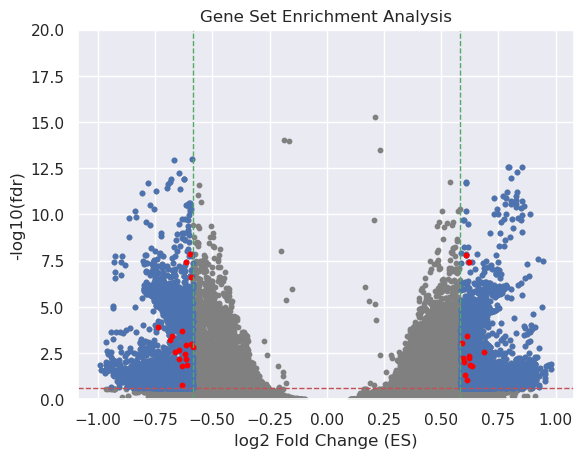

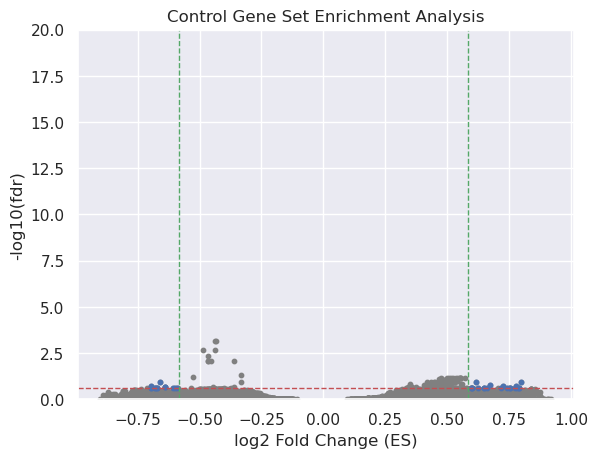

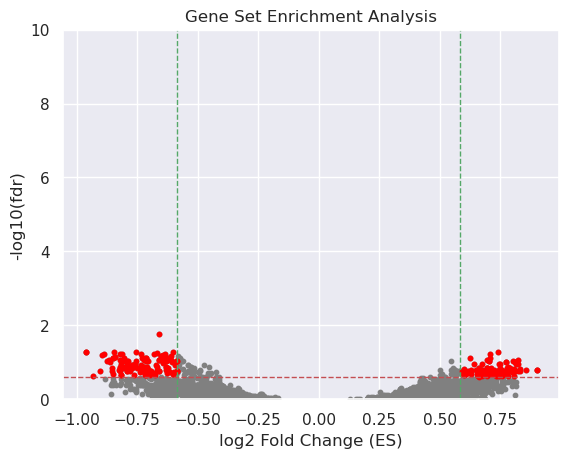

In [13]:
# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

pediatric_results = all_GSEA_results_df[
    all_GSEA_results_df['Term'].isin(significant_peds['Term']) &
    (all_GSEA_results_df['es'].abs() > lfc_cutoff) & 
    (all_GSEA_results_df['fdr'] < fdr_cutoff)
]

plt.figure()
plt.scatter(x=all_GSEA_results_df['es'],y=all_GSEA_results_df['fdr'].apply(lambda x:-np.log10(x)),s=10, color='grey')
plt.scatter(x=significant_gsea_df['es'],y=significant_gsea_df['fdr'].apply(lambda x:-np.log10(x)),s=10)
plt.scatter(x=pediatric_results['es'],y=pediatric_results['fdr'].apply(lambda x:-np.log10(x)) ,s=10, color='red')
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)


plt.figure()
plt.scatter(x=neg_GSEA_results_df['es'],y=neg_GSEA_results_df['fdr'].apply(lambda x:-np.log10(x)), s=10, color='grey')
plt.scatter(x=significant_negs['es'],y=significant_negs['fdr'].apply(lambda x:-np.log10(x)),s=10)
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,20)
plt.title('Control Gene Set Enrichment Analysis')

#save figure
cgsea_save_path = pathlib.Path("../1.data-exploration/figures/controlgsea.png")
plt.savefig(cgsea_save_path, bbox_inches="tight", dpi=600)


plt.figure()
plt.scatter(x=pediatric_GSEA_results_df['es'],y=pediatric_GSEA_results_df['fdr'].apply(lambda x:-np.log10(x)),s=10, color='grey')
plt.scatter(x=significant_peds['es'],y=significant_peds['fdr'].apply(lambda x:-np.log10(x)),s=10, color='red')
#LFC and FDR lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0,10)
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/ped_gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

In [14]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "M Phase R-HSA-68886"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "M Phase R-HSA-68886"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()